In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
from pylibs.transition_matrix import *

### data

In [3]:
df = pd.read_csv("taxis.csv")
print(f"{df.shape = }")
print(df.head().to_string())

df.shape = (6433, 14)
                pickup              dropoff  passengers  distance  fare   tip  tolls  total   color      payment            pickup_zone           dropoff_zone pickup_borough dropoff_borough
0  2019-03-23 20:21:09  2019-03-23 20:27:24           1      1.60   7.0  2.15    0.0  12.95  yellow  credit card        Lenox Hill West    UN/Turtle Bay South      Manhattan       Manhattan
1  2019-03-04 16:11:55  2019-03-04 16:19:00           1      0.79   5.0  0.00    0.0   9.30  yellow         cash  Upper West Side South  Upper West Side South      Manhattan       Manhattan
2  2019-03-27 17:53:01  2019-03-27 18:00:25           1      1.37   7.5  2.36    0.0  14.16  yellow  credit card          Alphabet City           West Village      Manhattan       Manhattan
3  2019-03-10 01:23:59  2019-03-10 01:49:51           1      7.70  27.0  6.15    0.0  36.95  yellow  credit card              Hudson Sq         Yorkville West      Manhattan       Manhattan
4  2019-03-30 13:27:42  2019

In [4]:
def get_data(df, hour_braket_size=6):
    df2 = df.copy()
    col_from, col_to = "pickup", "dropoff"
    assert col_from in df2.columns and col_to in df2.columns, f"columns {col_from} and {col_to} must be in dataframe"
    import random
    df2.loc[random.choices(df2.index, k=10), col_from] = np.nan
    df2.loc[random.choices(df2.index, k=10), col_to] = np.nan
    df2[f'{col_from}_braket'] = pd.to_datetime(df2[col_from]).dt.hour // hour_braket_size
    df2[f'{col_to}_braket'] = pd.to_datetime(df2[col_to]).dt.hour // hour_braket_size

    df2 = df2[[f"{col_from}_braket", f"{col_to}_braket", 'tip', 'fare']]

    return df2

In [5]:
def calc_signal(df):

    col_from, col_to = "pickup_braket", "dropoff_braket"
    assert col_from in df.columns and col_to in df.columns, f"columns {col_from} and {col_to} must be in dataframe"

    gdf = (
        df
        .groupby([col_from, col_to], dropna=False, observed=False, as_index=False)
        .agg(
            **{
                "n": (col_from, "size"),
                'signal': (col_from, lambda x: df.loc[x.index, 'tip'].sum()/df.loc[x.index, 'fare'].sum()),
            }
        )
    )
    return gdf


### data proc

In [6]:
df2 = get_data(df, hour_braket_size=3)
print(df2.head().to_string())

   pickup_braket  dropoff_braket   tip  fare
0            6.0             6.0  2.15   7.0
1            5.0             5.0  0.00   5.0
2            5.0             6.0  2.36   7.5
3            0.0             0.0  6.15  27.0
4            4.0             4.0  1.10   9.0


### plot basic

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Transition Matrix'}, xlabel='dropoff_braket', ylabel='pickup_braket'>,
 <matplotlib.image.AxesImage at 0x11f36680980>)

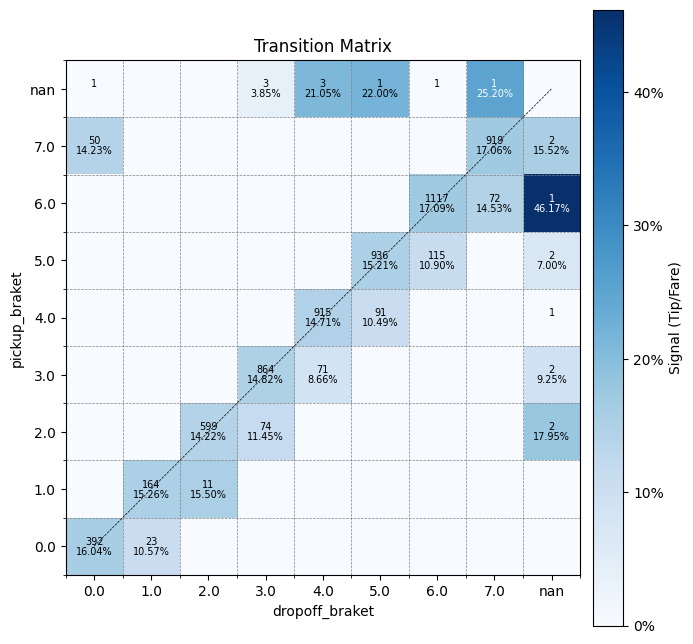

In [7]:
lsdf = calc_signal(df2)

from_col, to_col = "pickup_braket", "dropoff_braket"
spine = make_spine_from_cols(lsdf[from_col], lsdf[to_col])
lsdf = spine.merge(lsdf, on=[from_col, to_col], how="left")
pdf = lsdf.pivot(index=from_col, columns=to_col)

pdf_n = pdf.xs('n', axis=1, level=0).sort_index(axis=0,ascending=False,na_position='first').sort_index(axis=1).fillna(0)
pdf_sig = pdf.xs('signal', axis=1, level=0).sort_index(axis=0,ascending=False,na_position='first').sort_index(axis=1).fillna(0)

plot_transition_matrix(
    pdf_n = pdf_n,
    pdf_s = pdf_sig,
    n_fontsize = 7,
    s_fontsize = 7,
    figsize=(8, 8),
    title = "Transition Matrix",
    colorbar_label="Signal (Tip/Fare)",
)


(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Transition Matrix'}, xlabel='dropoff_braket', ylabel='pickup_braket'>,
 <matplotlib.image.AxesImage at 0x11f36a4e990>)

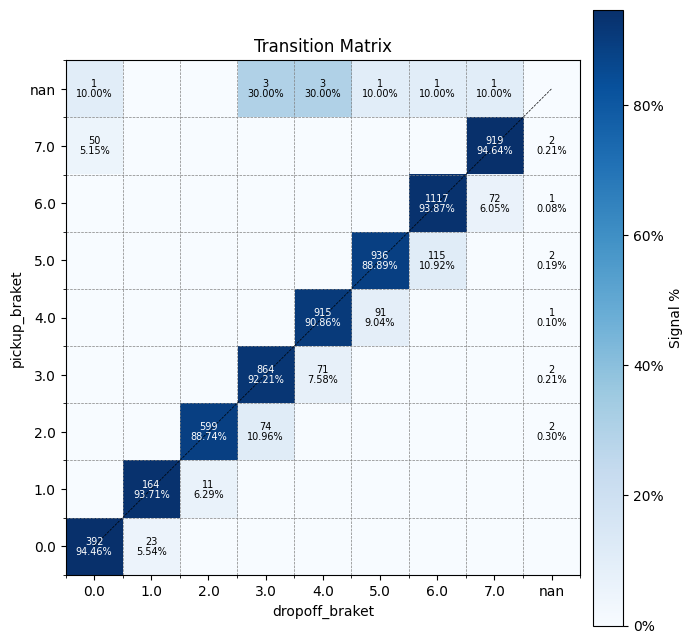

In [8]:
lsdf = calc_signal(df2)

from_col, to_col = "pickup_braket", "dropoff_braket"
spine = make_spine_from_cols(lsdf[from_col], lsdf[to_col])
lsdf = spine.merge(lsdf, on=[from_col, to_col], how="left")
pdf = lsdf.pivot(index=from_col, columns=to_col)

pdf_n = pdf.xs('n', axis=1, level=0).sort_index(axis=0,ascending=False,na_position='first').sort_index(axis=1).fillna(0)

plot_transition_matrix(
    pdf_n = pdf_n,
    n_fontsize = 7,
    s_fontsize = 7,
    figsize=(8, 8),
    title = "Transition Matrix",
)


(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Transition Matrix'}, xlabel='dropoff_braket', ylabel='pickup_braket'>,
 <matplotlib.image.AxesImage at 0x11f391a0e10>)

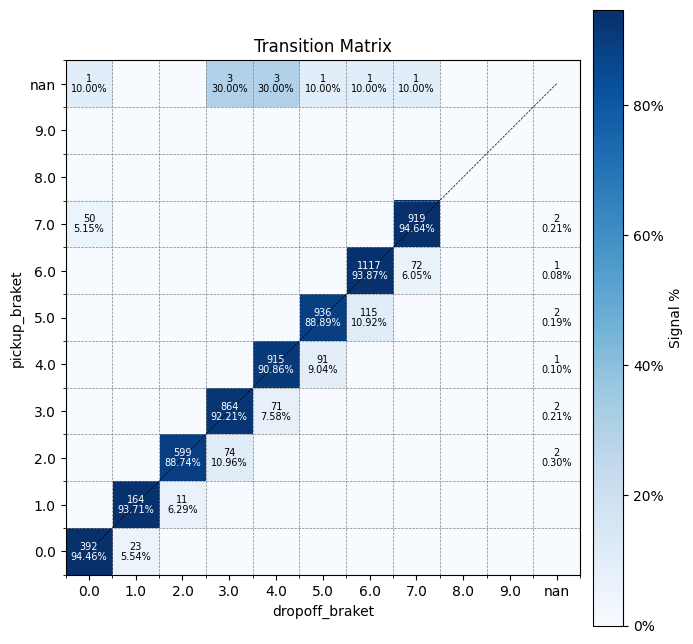

In [9]:
lsdf = calc_signal(df2)

from_col, to_col = "pickup_braket", "dropoff_braket"
spine = make_spine_from_cols(lsdf[from_col], lsdf[to_col])
lsdf = spine.merge(lsdf, on=[from_col, to_col], how="left")
pdf = lsdf.pivot(index=from_col, columns=to_col)

pdf_n = pdf.xs('n', axis=1, level=0)
new_index = list(range(0,10)) + [np.nan]
pdf_n = pdf_n.reindex(index=new_index, columns=new_index, fill_value=0)
pdf_n = pdf_n.sort_index(axis=0,ascending=False,na_position='first').sort_index(axis=1).fillna(0)
plot_transition_matrix(
    pdf_n = pdf_n,
    n_fontsize = 7,
    s_fontsize = 7,
    figsize=(8, 8),
    title = "Transition Matrix",
)


(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Transition Matrix'}, xlabel='dropoff_braket', ylabel='pickup_braket'>,
 <matplotlib.image.AxesImage at 0x11f396f0e10>)

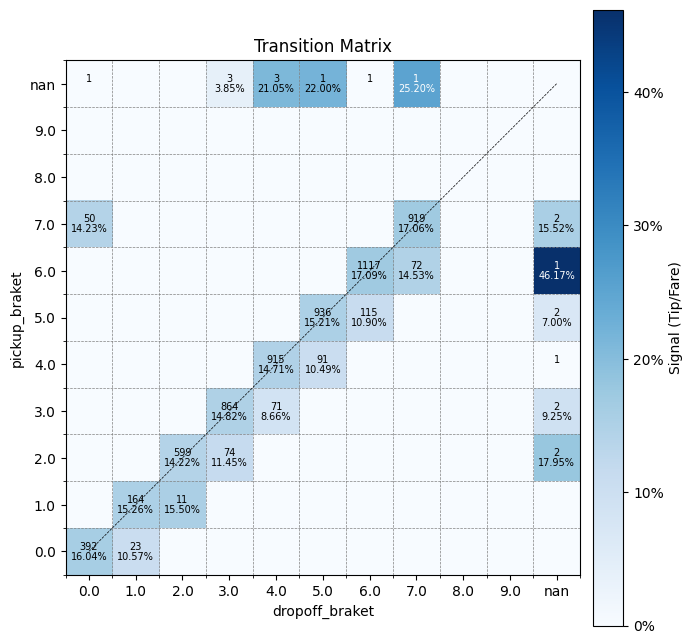

In [10]:
lsdf = calc_signal(df2)

_ = list(range(0,10)) + [np.nan]
pdf_n, pdf_s = calc_transition_matrixes_from_signal(
    signal_df = lsdf,
    from_col = "pickup_braket",
    to_col = "dropoff_braket",
    n_col="n",
    signal_col="signal",
    from_levels = _,
    to_levels = _,
)

plot_transition_matrix(
    pdf_n = pdf_n,
    pdf_s = pdf_s,
    n_fontsize = 7,
    s_fontsize = 7,
    figsize=(8, 8),
    title = "Transition Matrix",
    colorbar_label="Signal (Tip/Fare)",
)

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Transition Matrix'}, xlabel='dropoff_braket', ylabel='pickup_braket'>,
 <matplotlib.image.AxesImage at 0x11f39c50b90>)

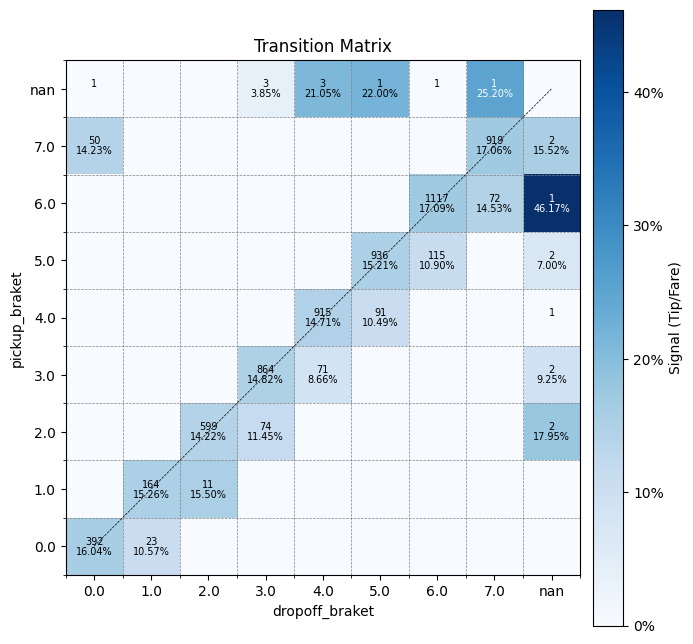

In [11]:
lsdf = calc_signal(df2)

pdf_n, pdf_s = calc_transition_matrixes_from_signal(
    signal_df = lsdf,
    from_col = "pickup_braket",
    to_col = "dropoff_braket",
    n_col="n",
    signal_col="signal",
)

plot_transition_matrix(
    pdf_n = pdf_n,
    pdf_s = pdf_s,
    n_fontsize = 7,
    s_fontsize = 7,
    figsize=(8, 8),
    title = "Transition Matrix",
    colorbar_label="Signal (Tip/Fare)",
)

### plot advanced

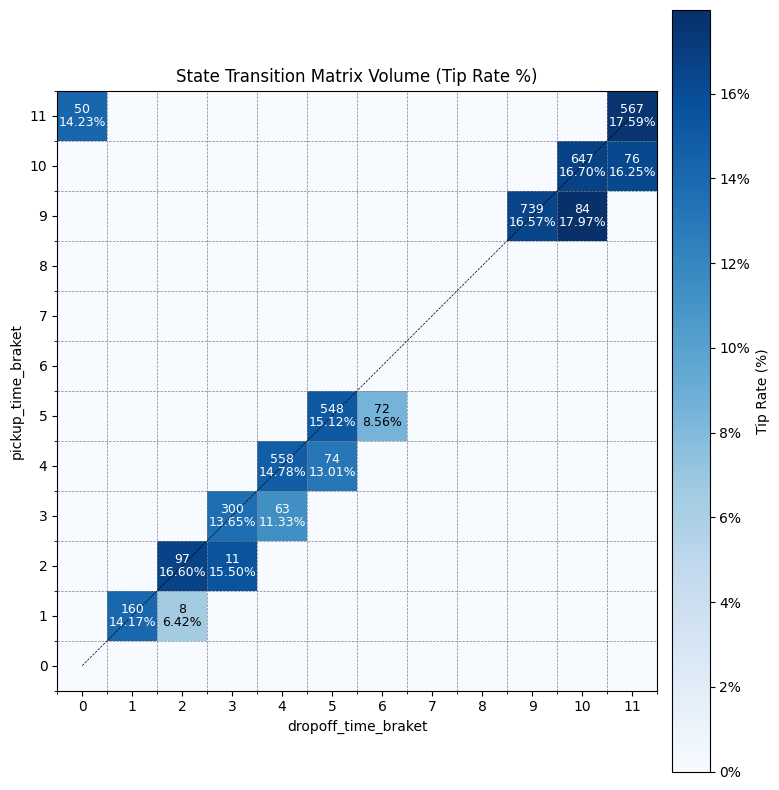

In [ ]:
# plot_transition_matrix(
#     tm_df=pdf.sort_index(ascending=False),
#     color_tm_df=pdf_tip_pct.sort_index(ascending=False),
#     bottom_tm_df=pdf_tip_pct.sort_index(ascending=False),
#     title="State Transition Matrix Volume (Tip Rate %)",
#     ax=None,
#     figsize=(8, 8),
#     fontsize=9,
#     colorbar_label="Tip Rate (%)"
# )
# plt.tight_layout()

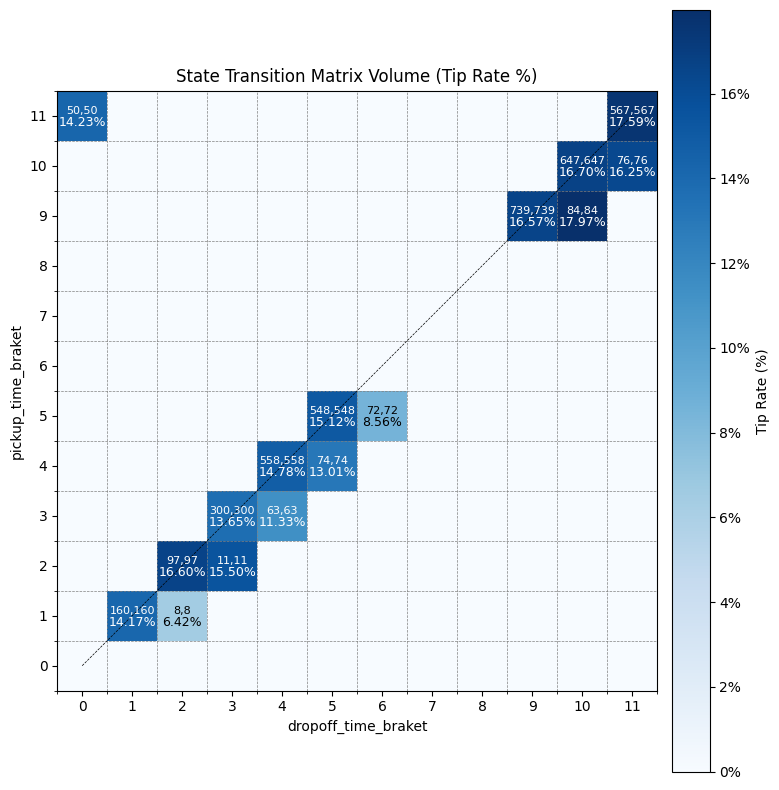

In [ ]:
# plot_transition_matrix(
#     tm_df=pdf_str.sort_index(ascending=False),
#     color_tm_df=pdf_tip_pct.sort_index(ascending=False),
#     bottom_tm_df=pdf_tip_pct.sort_index(ascending=False),
#     tm_formatter=lambda x: f"{x}" if x != "0,0" else "",
#     title="State Transition Matrix Volume (Tip Rate %)",
#     ax=None,
#     figsize=(8, 8),
#     fontsize=8,
#     fontsize_bottom=9,
#     colorbar_label="Tip Rate (%)"
# )
# plt.tight_layout()

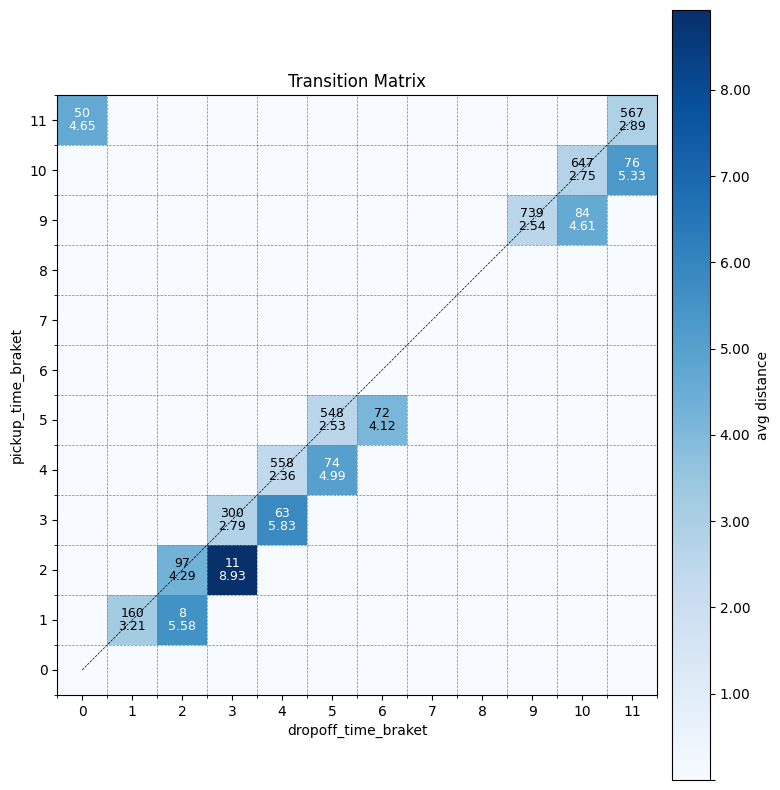

In [ ]:
# plot_transition_matrix(
#     tm_df=pdf.sort_index(ascending=False),
#     color_tm_df=pdf_avg_distance.sort_index(ascending=False),
#     bottom_tm_df=pdf_avg_distance.sort_index(ascending=False),
#     bottom_tm_formatter=lambda x: f"{x:.2f}" if x != 0 else "",
#     title="Transition Matrix",
#     ax=None,
#     figsize=(8, 8),
#     fontsize=9,
#     colorbar_label="avg distance",
#     colorbar_formatter=lambda x, _: f"{x:.2f}" if x != 0 else "",
# )
# plt.tight_layout()

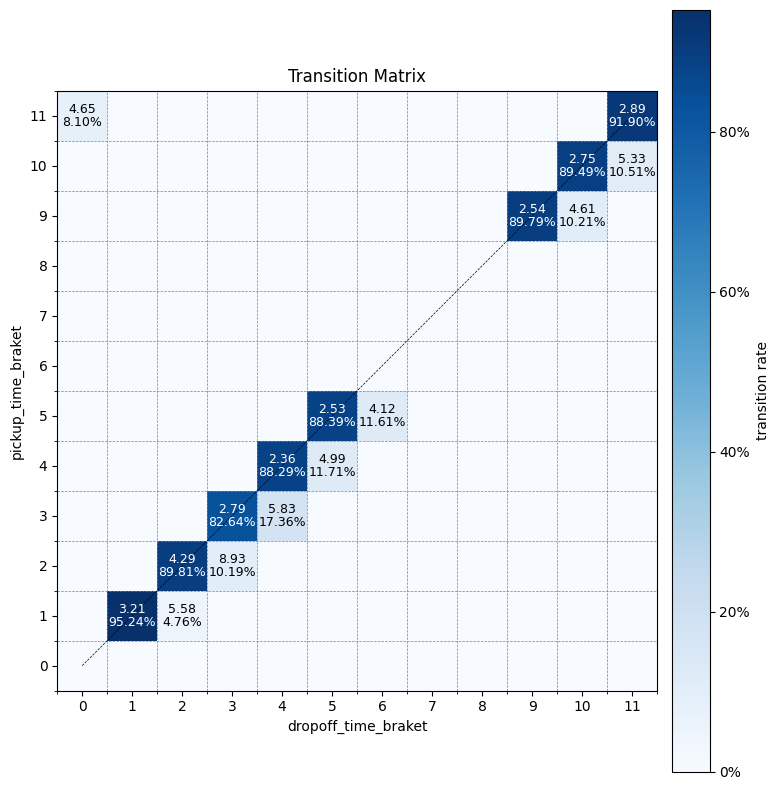

In [ ]:
# plot_transition_matrix(
#     tm_df=pdf_avg_distance.sort_index(ascending=False),
#     color_tm_df=pdf_hori_distn_pct.sort_index(ascending=False),
#     bottom_tm_df=pdf_hori_distn_pct.sort_index(ascending=False),
#     tm_formatter=lambda x: f"{x:.2f}" if x != 0 else "",
#     title="Transition Matrix",
#     ax=None,
#     figsize=(8, 8),
#     fontsize=9,
#     colorbar_label="transition rate",
# )
# plt.tight_layout()

In [ ]:
# 